<a href="https://colab.research.google.com/github/sungkim11/forecast-sales/blob/main/forecast_sales_using_prophet_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Forecast Sales Using Prophet

## 1. Prequisites

Following are prerequisite for this tutorial:
- Data
- Python Package: fbprophet or Facebook Prophet

### 1.1. Data

Three data sources were used for this tutorial where United Stated Census Bureau Monthly Retail Sales is used to forecast future sales and  both FRED Data and OECD Data were used as Regressors data.

**United Stated Census Bureau Monthly Retail Sales**<BR>
United Stated Census Bureau maintains Monthly Retail Trade Report, from January 1992 to Present. This data was picked to illustrate forecasting because it has extensive historical data with same monthly frequency. Data is available as Excel spreadsheet format at https://www.census.gov/retail/mrts/www/mrtssales92-present.xls

**FRED Data: https://fred.stlouisfed.org/**
- Inflation
- CPI
- M1
- M2
- Interest Rate

**OECD Data: https://data.oecd.org/leadind/composite-leading-indicator-cli.htm#indicator-chart**
- Composite leading indicator (CLI)
- Business confidence index (BCI)
- Consumer confidence index (CCI)

### 1.2. Python Packages

#### 1.2.1. Install Prophet

**Please  note  that  you  only  need  to  run install  once.**

In [ ]:
!pip install pystan==2.19.1.1

In [ ]:
!pip install fbprophet

## 2. Code

#### 2.1. Import Python Package

Import python packages and show its version. Showing version is important since it will enable other users to replicate your work using same python version and python packages version.

In [1]:
import pandas as pd
import matplotlib as plt
import fbprophet
from fbprophet import Prophet
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
import platform

from pandas.tseries.offsets import MonthBegin
from pandas.tseries.offsets import MonthEnd

from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric

print('Python: ', platform.python_version())
print('pandas: ', pd.__version__)
print('matplotlib: ', plt.__version__)
print('Prophet: ', fbprophet.__version__)
print('statsmodels: ', statsmodels.__version__)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Python:  3.7.13
pandas:  1.3.5
matplotlib:  3.2.2
Prophet:  0.7.1
statsmodels:  0.10.2


### 2.2. Mount Storage

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.3. Exploratory Data Analysis

#### Import and validate dataset

In [3]:
retail_sales = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/forecast-sales/data/mrtssales92-present.csv', index_col = 0)
retail_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205 entries, 1/1/2005 to 1/1/2022
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   sales_total  205 non-null    int64
dtypes: int64(1)
memory usage: 3.2+ KB


In [4]:
retail_sales.head(5)

,sales_total
month,
1/1/2005,293261
2/1/2005,295062
3/1/2005,339141
4/1/2005,335632
5/1/2005,345348


#### Set Index then convert month date to month-end because of fbprophet's use of month-end date.

In [5]:
retail_sales.index = pd.to_datetime(retail_sales.index)
retail_sales.reset_index(inplace = True)
retail_sales['month'] = pd.to_datetime(retail_sales['month']) + MonthEnd(1)
retail_sales.set_index(['month'], inplace = True)
retail_sales.index = pd.to_datetime(retail_sales.index)
retail_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 205 entries, 2005-01-31 to 2022-01-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   sales_total  205 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


In [6]:
retail_sales.head(5)

,sales_total
month,
2005-01-31,293261
2005-02-28,295062
2005-03-31,339141
2005-04-30,335632
2005-05-31,345348


#### Split Datasets

Split datasets:
- Actuals
- Train
- Test
- Validate
- Cross Validate

In [7]:
retail_sales_actuals = retail_sales.loc['2005-01-01':'2018-12-31']
retail_sales_train = retail_sales_actuals.loc['2005-01-01':'2016-12-31']
retail_sales_test = retail_sales_actuals.loc['2017-01-01':'2018-12-31']
retail_sales_traintest = retail_sales_actuals.loc['2005-01-01':'2018-12-31']
retail_sales_validate = retail_sales.loc['2019-01-01':'2021-12-31']
retail_sales_cross_validate = retail_sales.loc['2017-01-01':'2021-12-31']

print('Actuals: ', retail_sales_actuals.shape)
print('Train: ', retail_sales_train.shape)
print('Test: ', retail_sales_test.shape)
print('Train and Test: ', retail_sales_traintest.shape)
print('Validate: ', retail_sales_validate.shape)
print('Cross Validate: ', retail_sales_cross_validate.shape)

Actuals:  (168, 1)
Train:  (144, 1)
Test:  (24, 1)
Train and Test:  (168, 1)
Validate:  (36, 1)
Cross Validate:  (60, 1)


#### Set Plotting Parameters

In [8]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 12 and height to 9
fig_size[0] = 30
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

#### Chart Retail Sales

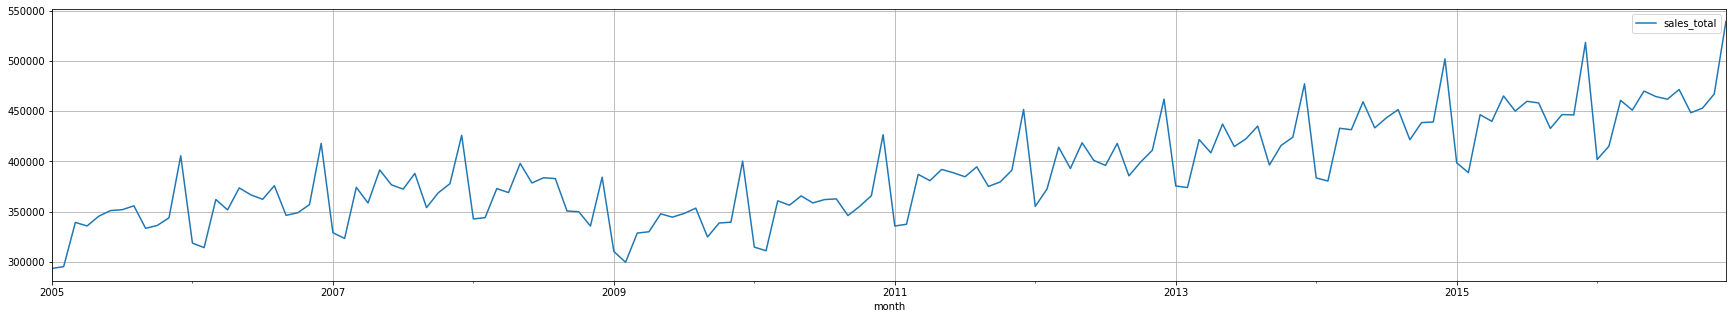

In [9]:
retail_sales_train.reset_index().plot(x='month', y='sales_total', kind='line', grid=1)
plt.pyplot.show()

#### Determine Retail Sales Data (Time-Series) has trend

Next, we need to determine if the retail sales data is non-stationary or it has trends using Dickey Fuller Test, which is a statistical hypothesis test that allows you to detect non-stationarity. The stationary time-series implies there is no predictable pattern in the long term.

In [10]:
from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(retail_sales_train.sales_total.values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -0.41114662261582896
ADF p-values: 0.9082209893408628
ADF number of lags used: 14
ADF number of observations: 129
ADF critical values: {'1%': -3.482087964046026, '5%': -2.8842185101614626, '10%': -2.578864381347275}
ADF best information criterion: 2712.938864098956


Looking at the value, which is bigger than 0.05, you can determine time-series data is non-stationary.

#### Decompose Retail Sales to Determine Which Model to Use

Decomposition is primarily used for time series analysis, and as an analysis tool it can be used to inform forecasting models on your problem.

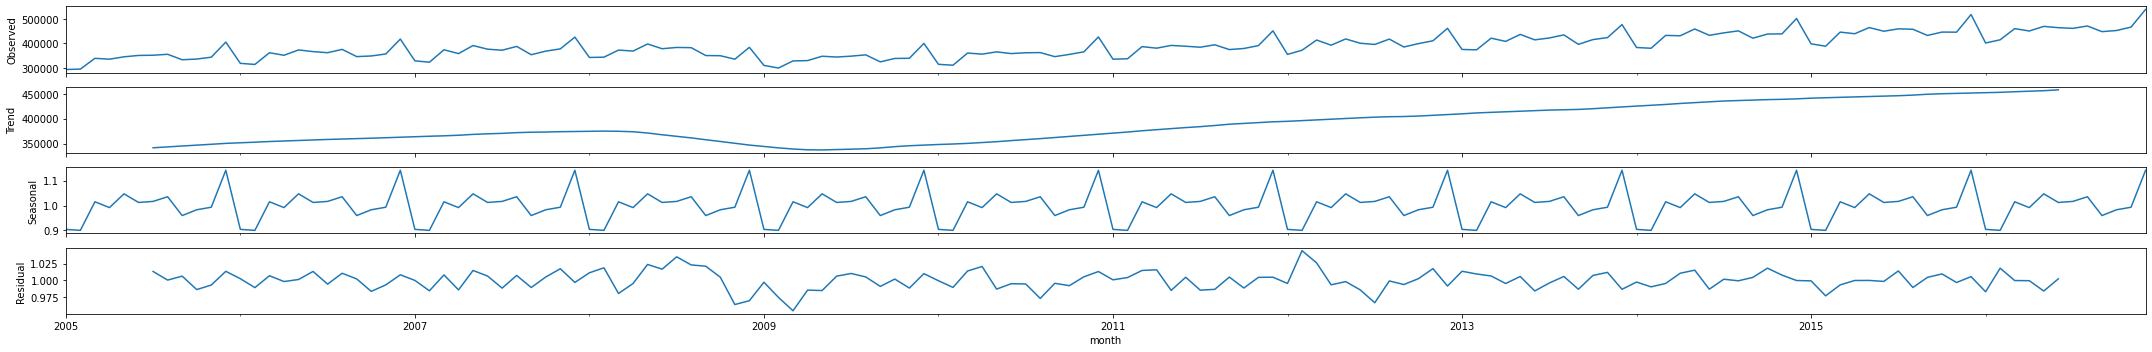

In [11]:
retail_sales_train.index = pd.to_datetime(retail_sales_train.index)
retail_sales_train_decompose_result = seasonal_decompose(retail_sales_train, model='multiplicative')
retail_sales_train_decompose_result.plot().show()

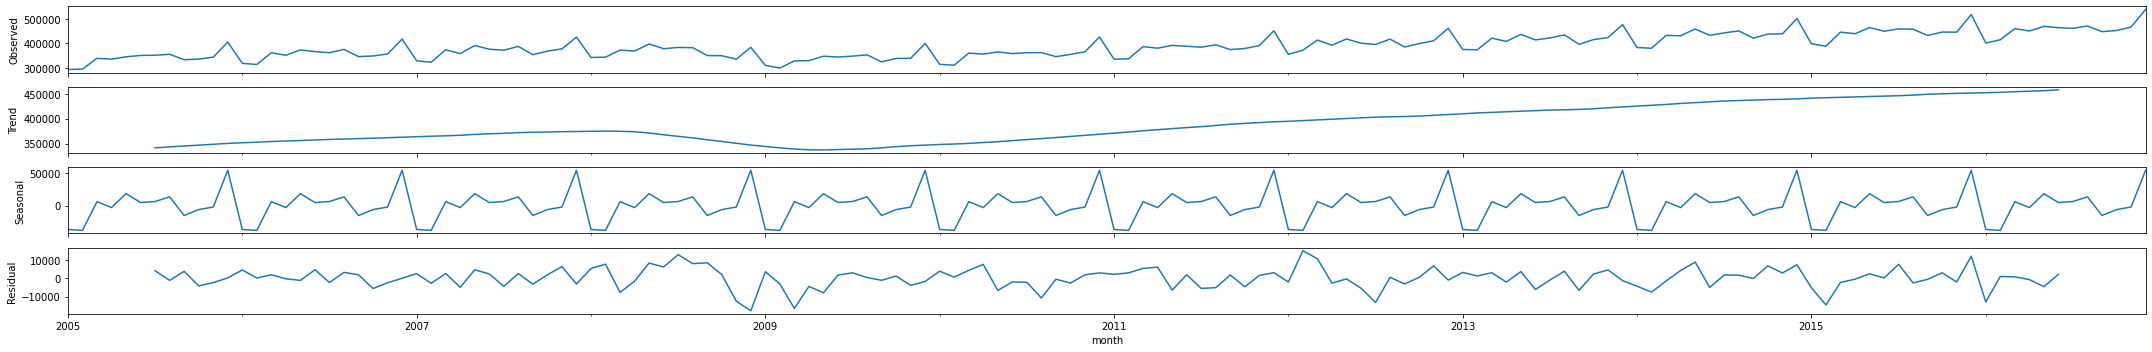

In [12]:
retail_sales_train_decompose_result = seasonal_decompose(retail_sales_train, model='additive')
retail_sales_train_decompose_result.plot().show()

Looking at Residual chart, multiplicative chart is smoother, so we will use multiplicative model.

#### Prep Train Dataset

In [ ]:
retail_sales_train = retail_sales_train.reset_index()
retail_sales_train.columns = ['ds', 'y']
retail_sales_train.head()

,ds,y
0,2005-01-31,293261
1,2005-02-28,295062
2,2005-03-31,339141
3,2005-04-30,335632
4,2005-05-31,345348


#### Develop and Fit Forecast Model then Forecast Sales (for Test) using Forecast Model

In [ ]:
retail_sales_model = Prophet(yearly_seasonality=True,  seasonality_mode='multiplicative')
retail_sales_model.fit(retail_sales_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
retail_sales_future = retail_sales_model.make_future_dataframe(freq='M', periods=24)
retail_sales_future.head(5)

,ds
0,2005-01-31
1,2005-02-28
2,2005-03-31
3,2005-04-30
4,2005-05-31


In [ ]:
retail_sales_forecast = retail_sales_model.predict(retail_sales_future)
retail_sales_forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
163,2018-08-31,489824.006490,489401.829801,518779.608557,475600.205042,502374.138731,0.029297,0.029297,0.029297,0.029297,0.029297,0.029297,0.0,0.0,0.0,504174.353042
164,2018-09-30,490937.240469,454292.180454,485046.106419,475682.170484,504481.284952,-0.042521,-0.042521,-0.042521,-0.042521,-0.042521,-0.042521,0.0,0.0,0.0,470062.121026
165,2018-10-31,492087.582248,466303.273309,499479.837914,475546.802463,506480.160948,-0.018602,-0.018602,-0.018602,-0.018602,-0.018602,-0.018602,0.0,0.0,0.0,482933.722614
166,2018-11-30,493200.816228,472444.025297,506824.259168,475427.720815,508793.135181,-0.005855,-0.005855,-0.005855,-0.005855,-0.005855,-0.005855,0.0,0.0,0.0,490313.050102
167,2018-12-31,494351.158007,542595.851443,585629.662482,475693.345158,510818.483929,0.142955,0.142955,0.142955,0.142955,0.142955,0.142955,0.0,0.0,0.0,565021.312499


#### Chart Sales Forecast

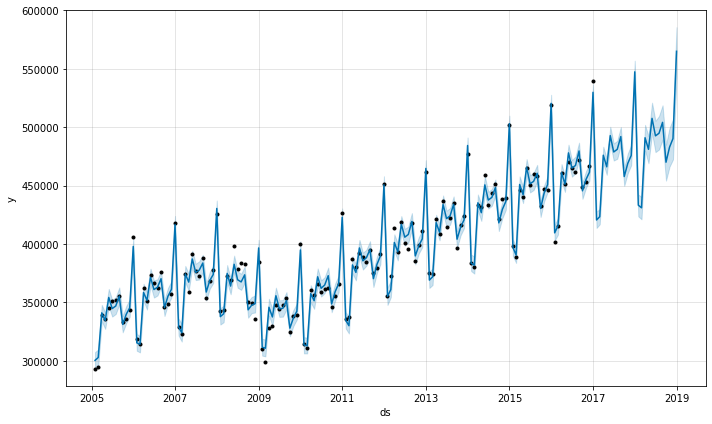

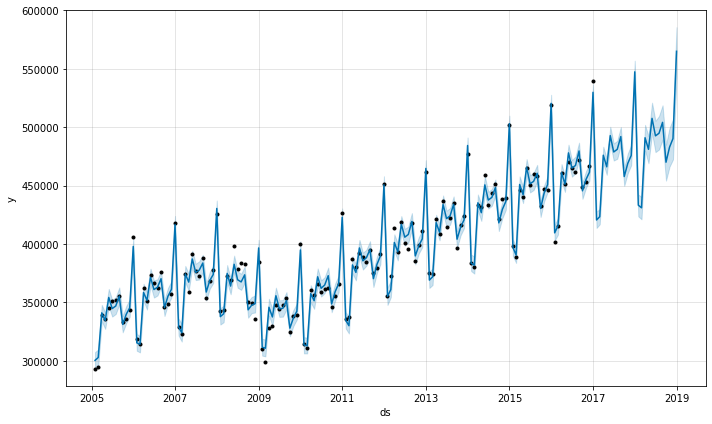

In [ ]:
retail_sales_model.plot(retail_sales_forecast)

#### Chart Sales Forecast Components

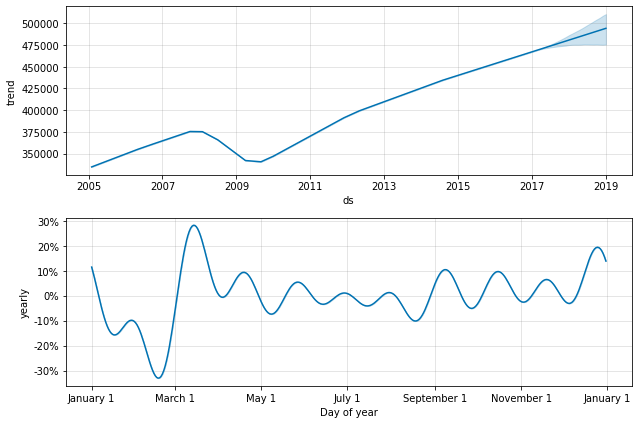

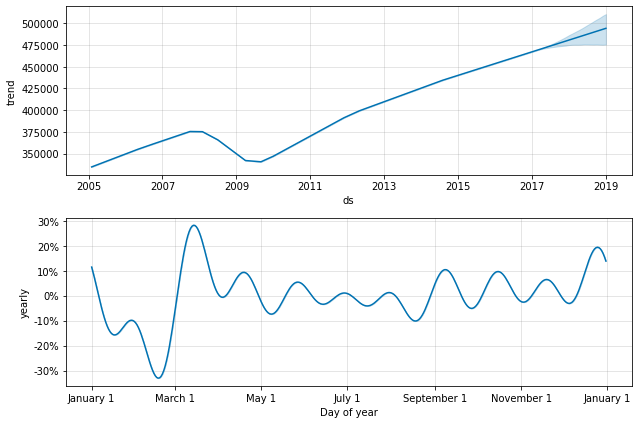

In [ ]:
retail_sales_model.plot_components(retail_sales_forecast)

#### Validate Sales Forecast  -  Prophet  Validation Method



In [ ]:
retail_sales_cv = cross_validation(retail_sales_model, initial = '1825 days', period='365 days', horizon=' 2190 days', parallel='processes')
retail_sales_cv.tail(5)

INFO:fbprophet:Making 1 forecasts with cutoffs between 2011-01-02 00:00:00 and 2011-01-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8291b32950>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
67,2016-08-31,493466.487462,313469.989843,689645.841785,471690,2011-01-02
68,2016-09-30,461083.433239,290580.164940,649178.712722,448516,2011-01-02
69,2016-10-31,469060.614670,291789.673907,665279.713409,453155,2011-01-02
70,2016-11-30,464921.776201,286728.982943,660594.393685,467232,2011-01-02
71,2016-12-31,551675.867105,337140.027727,790196.479251,539667,2011-01-02


In [ ]:
retail_sales_p = performance_metrics(retail_sales_cv)
retail_sales_p.tail(5)

,horizon,mse,rmse,mae,mape,mdape,coverage
61,2068 days,2.893471e+08,17010.206257,15335.536447,0.033403,0.030876,1.0
62,2098 days,2.958546e+08,17200.423091,15616.407549,0.033758,0.030876,1.0
63,2129 days,3.302066e+08,18171.587959,17383.073329,0.037675,0.035100,1.0
64,2159 days,3.098446e+08,17602.403123,15975.929391,0.034531,0.035100,1.0
65,2190 days,2.899999e+08,17029.383820,15287.719198,0.032596,0.030876,1.0


/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


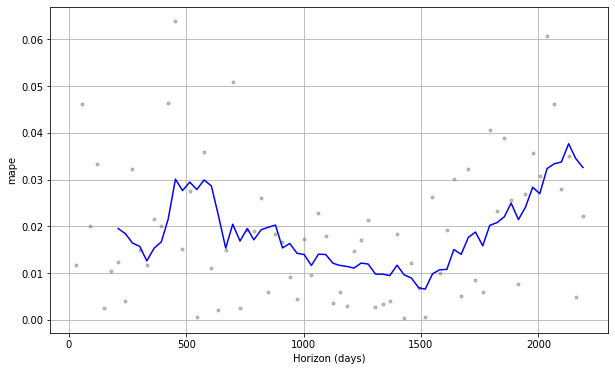

In [ ]:
fig = plot_cross_validation_metric(retail_sales_cv, metric='mape')

In [ ]:
retail_sales_p.mean()

horizon     1199 days 18:10:54.545454544
mse                     101863839.525094
rmse                         9389.520874
mae                          7933.454062
mape                            0.018631
mdape                           0.016724
coverage                        0.935065
dtype: object

####Validate Sales Forecast - Forecast All  Methods

In [ ]:
retail_sales_forecast_filtered = retail_sales_forecast.filter(["ds","yhat"])
retail_sales_forecast_filtered.head(5)

,ds,yhat
0,2005-01-31,300420.057887
1,2005-02-28,302874.691863
2,2005-03-31,341106.290375
3,2005-04-30,334536.828824
4,2005-05-31,354276.296700


In [ ]:
retail_sales_forecast_filtered.columns = ['Month', 'Prediction']
retail_sales_forecast_filtered = retail_sales_forecast_filtered.set_index('Month')
retail_sales_validate = pd.DataFrame(retail_sales_forecast_filtered, index =retail_sales_test.index, columns=['Prediction'])
retail_sales_validate = pd.concat([retail_sales_test, retail_sales_validate], axis=1)
retail_sales_validate.head(5)

,sales_total,Prediction
month,,
2017-01-31,421943,420613.811315
2017-02-28,418315,423404.840065
2017-03-31,483082,476052.073594
2017-04-30,465788,466131.646382
2017-05-31,494621,492819.599682


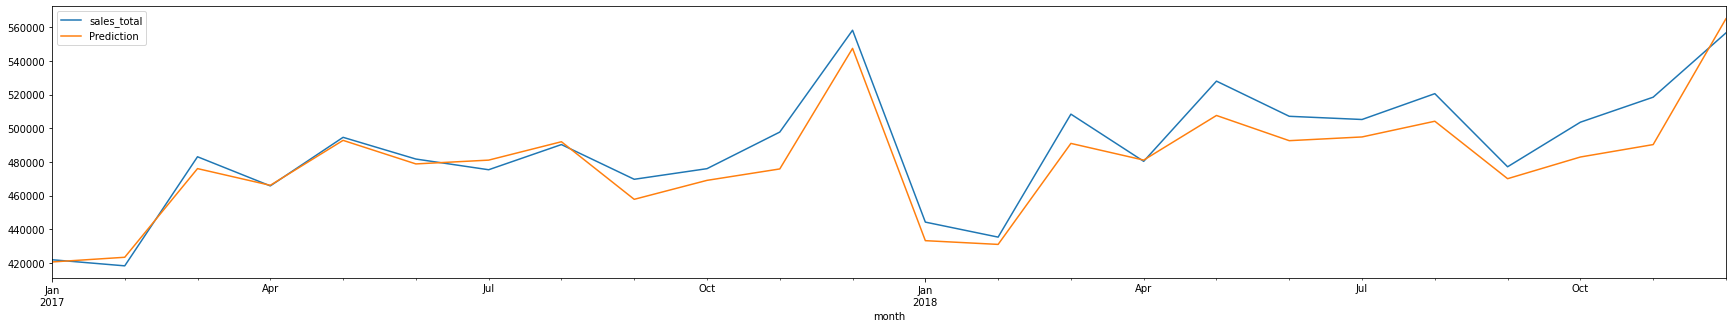

In [ ]:
retail_sales_validate.plot()
plt.pyplot.show()

In [ ]:
retail_sales_validate['Abs Diff'] = (retail_sales_validate['sales_total'] - retail_sales_validate['Prediction']).abs()
retail_sales_validate['Abs Diff %'] = (retail_sales_validate['sales_total'] - retail_sales_validate['Prediction']).abs()/retail_sales_validate['sales_total']
retail_sales_validate.loc['Average Abs Diff %'] = pd.Series(retail_sales_validate['Abs Diff %'].mean(), index = ['Abs Diff %'])
retail_sales_validate.loc['Min Abs Diff %'] = pd.Series(retail_sales_validate['Abs Diff %'].min(), index = ['Abs Diff %'])
retail_sales_validate.loc['Max Abs Diff %'] = pd.Series(retail_sales_validate['Abs Diff %'].max(), index = ['Abs Diff %'])
retail_sales_validate.tail(10)

,sales_total,Prediction,Abs Diff,Abs Diff %
month,,,,
2018-06-30 00:00:00,507106.0,492632.635939,14473.364061,0.028541
2018-07-31 00:00:00,505209.0,494846.042623,10362.957377,0.020512
2018-08-31 00:00:00,520544.0,504174.353042,16369.646958,0.031447
2018-09-30 00:00:00,477137.0,470062.121026,7074.878974,0.014828
2018-10-31 00:00:00,503602.0,482933.722614,20668.277386,0.041041
2018-11-30 00:00:00,518457.0,490313.050102,28143.949898,0.054284
2018-12-31 00:00:00,556614.0,565021.312499,8407.312499,0.015104
Average Abs Diff %,NaN,NaN,NaN,0.019739
Min Abs Diff %,NaN,NaN,NaN,0.000738


####  Forecast Sales All using same Forecast Model

Using same forecast model, forecast sales for all months till Deceomber 2021.

In [ ]:
retail_sales_future_all = retail_sales_model.make_future_dataframe(freq='M', periods=60)
retail_sales_forecast_all = retail_sales_model.predict(retail_sales_future_all)
retail_sales_forecast_all.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
199,2021-08-31,530494.154546,482787.305526,613256.910078,466345.792595,593188.907264,0.033014,0.033014,0.033014,0.033014,0.033014,0.033014,0.0,0.0,0.0,548008.119481
200,2021-09-30,531607.388525,445896.013948,571704.746508,465996.448592,596302.820823,-0.041018,-0.041018,-0.041018,-0.041018,-0.041018,-0.041018,0.0,0.0,0.0,509802.045504
201,2021-10-31,532757.730304,455538.940171,586918.027162,465009.730376,598207.703350,-0.019792,-0.019792,-0.019792,-0.019792,-0.019792,-0.019792,0.0,0.0,0.0,522213.573825
202,2021-11-30,533870.964284,459795.257648,599041.274669,464545.157704,600731.268352,-0.007925,-0.007925,-0.007925,-0.007925,-0.007925,-0.007925,0.0,0.0,0.0,529640.131009
203,2021-12-31,535021.306063,527454.104609,689297.469676,464561.641553,604803.460476,0.138576,0.138576,0.138576,0.138576,0.138576,0.138576,0.0,0.0,0.0,609162.267241


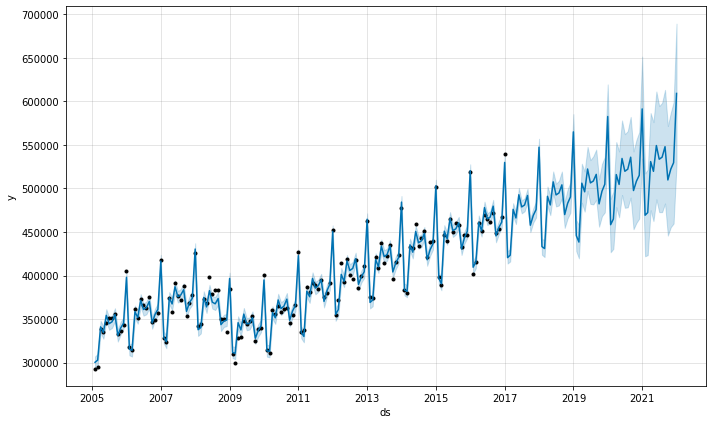

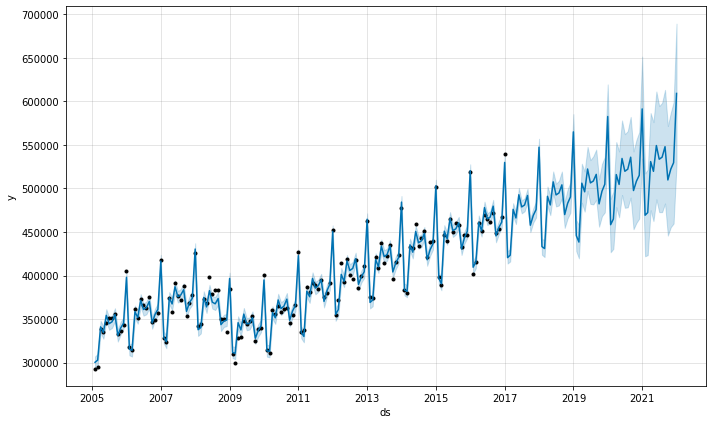

In [ ]:
retail_sales_model.plot(retail_sales_forecast_all)

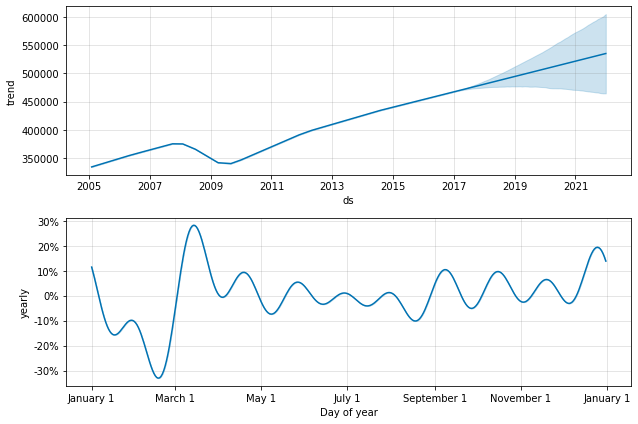

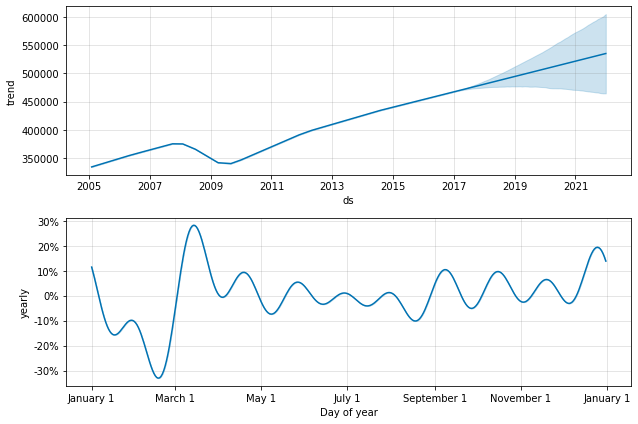

In [ ]:
retail_sales_model.plot_components(retail_sales_forecast_all)

####  Validate Sales All Forecast - All Forecast Methodology

Please  note  that  forecast  will  not  perform  well  for  both  calendar  year  2020  and  2021.

In [ ]:
retail_sales_forecast_all_filtered = retail_sales_forecast_all.filter(["ds","yhat"])
retail_sales_forecast_all_filtered.head(5)

,ds,yhat
0,2005-01-31,300420.057887
1,2005-02-28,302874.691863
2,2005-03-31,341106.290375
3,2005-04-30,334536.828824
4,2005-05-31,354276.296700


In [ ]:
retail_sales_forecast_all_filtered.columns = ['Month', 'Prediction']
retail_sales_forecast_all_filtered = retail_sales_forecast_all_filtered.set_index('Month')
retail_sales_validate_all = pd.DataFrame(retail_sales_forecast_all_filtered, index =retail_sales_cross_validate.index, columns=['Prediction'])
retail_sales_validate_all = pd.concat([retail_sales_cross_validate, retail_sales_validate_all], axis=1)
retail_sales_validate_all.head(5)

,sales_total,Prediction
month,,
2017-01-31,421943,420613.811315
2017-02-28,418315,423404.840065
2017-03-31,483082,476052.073594
2017-04-30,465788,466131.646382
2017-05-31,494621,492819.599682


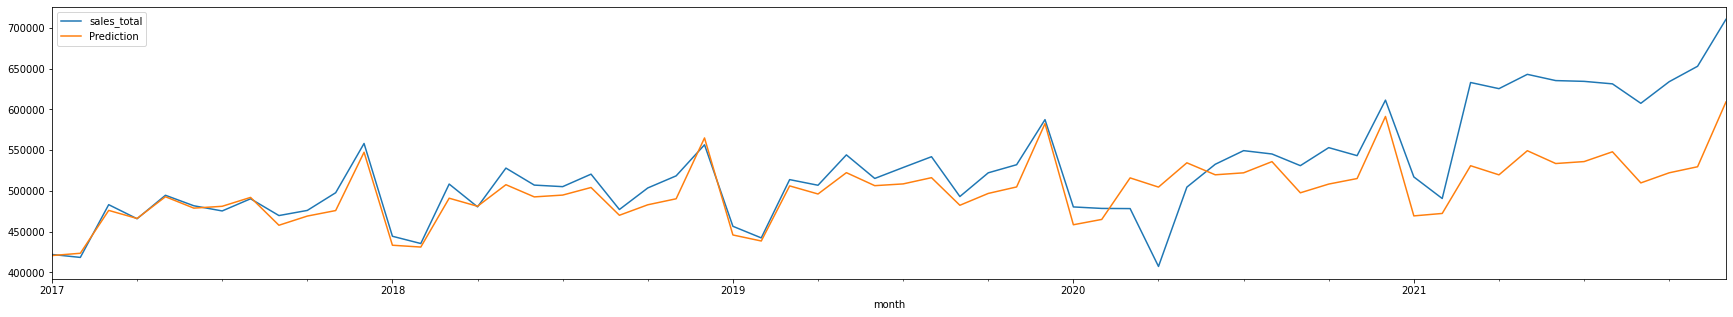

In [ ]:
retail_sales_validate_all.plot()
plt.pyplot.show()

In [ ]:
retail_sales_validate_all['Abs Diff'] = (retail_sales_validate_all['sales_total'] - retail_sales_validate_all['Prediction']).abs()
retail_sales_validate_all['Abs Diff %'] = (retail_sales_validate_all['sales_total'] - retail_sales_validate_all['Prediction']).abs()/retail_sales_validate_all['sales_total']
retail_sales_validate_all.loc['Average Abs Diff %'] = pd.Series(retail_sales_validate_all['Abs Diff %'].mean(), index = ['Abs Diff %'])
retail_sales_validate_all.loc['Min Abs Diff %'] = pd.Series(retail_sales_validate_all['Abs Diff %'].min(), index = ['Abs Diff %'])
retail_sales_validate_all.loc['Max Abs Diff %'] = pd.Series(retail_sales_validate_all['Abs Diff %'].max(), index = ['Abs Diff %'])
retail_sales_validate_all.tail(10)

,sales_total,Prediction,Abs Diff,Abs Diff %
month,,,,
2021-06-30 00:00:00,635437.0,533601.285075,101835.714925,0.160261
2021-07-31 00:00:00,634486.0,535978.608250,98507.391750,0.155255
2021-08-31 00:00:00,631415.0,548008.119481,83406.880519,0.132095
2021-09-30 00:00:00,607540.0,509802.045504,97737.954496,0.160875
2021-10-31 00:00:00,634076.0,522213.573825,111862.426175,0.176418
2021-11-30 00:00:00,653011.0,529640.131009,123370.868991,0.188926
2021-12-31 00:00:00,710619.0,609162.267241,101456.732759,0.142772
Average Abs Diff %,NaN,NaN,NaN,0.055128
Min Abs Diff %,NaN,NaN,NaN,0.000738
